In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [3]:
cleanDF=pd.read_csv('output.csv')[['Unnamed: 0','제목','본문']]
scoreDF1 = pd.read_csv('가중치점수1.csv',index_col=0)
scoreDF2 = pd.read_csv('가중치가치점수1.csv',index_col=0)

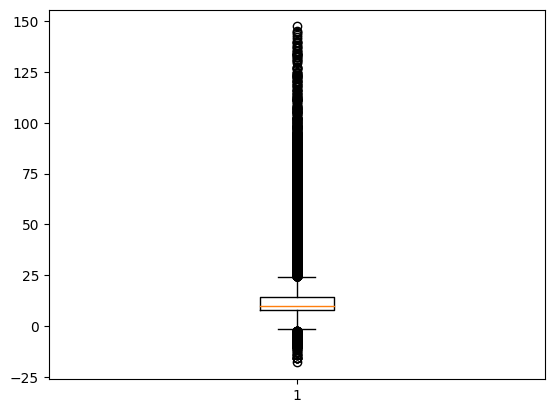

In [4]:
plt.boxplot(scoreDF1)
plt.show()

이상치 지우고 점수의 상,중,하로 분류

In [5]:
q1 = scoreDF1['0'].quantile(0.25)
q3 = scoreDF1['0'].quantile(0.75)
iqr = q3 - q1
scoreDF1 = scoreDF1[(scoreDF1 <= q3 + 1.5*iqr ) &(scoreDF1 >= q1 -1.5*iqr)].fillna(0)

In [6]:
q1 = scoreDF2['0'].quantile(0.25)
q3 = scoreDF2['0'].quantile(0.75)
iqr = q3 - q1
scoreDF2 = scoreDF2[(scoreDF2 <= q3 + 1.5*iqr ) &(scoreDF2 >= q1 - 1.5*iqr)].fillna(0)

In [7]:
scoreDF = scoreDF1 + scoreDF2
ndf = pd.concat([cleanDF.set_index('Unnamed: 0'),scoreDF ], axis=1)
ndf = ndf[ndf != 0].dropna()
ndf.to_csv('신뢰도분석파일.csv', encoding='utf-8')

### 타겟생성_상,중,하

In [8]:
ndf['rank'] = ndf['0'].rank(method='first')
ndf.sort_values('rank',inplace=True)
one3, two3 = ndf['rank'].quantile([0.2,0.6])
ndf['상중하'] = ndf['rank'].apply(lambda x: 2 if x >= two3 else 1 if x >= one3 else 0)
ndf.to_csv('신뢰도분석파일.csv', encoding='utf-8')

In [9]:
ndf

,제목,본문,0,rank,상중하
949,1월11일 인사,행정안전부 전보 과장급 이북5도 황해도 사무국장 배이철 대통령기록관 생산지...,-2.463000,1.0,0
971,[인사] 국무조정실 국무총리비서실 외,국무조정실 국무총리비서실 과장급 용산공원조성추진기획단 기획총괄 김민정 행정안전...,-2.463000,2.0,0
2723,[인사] 한국일보 외,룸국 차장 선임 김지은 차장대우 산업1부 이윤주 이슈365팀 김청환 스...,-2.463000,3.0,0
2819,[인사]문화일보 外,논설고문 이철호 교육부 교육부일반직고위공무원 김일수 책임교육정책실장 오승걸 울산광...,-2.463000,4.0,0
2963,오늘의 인사 - 2023년 1월 2일,보직 논설위원실 논설위원 안홍욱 신문국 정치에디터 김진우 국제에디터 조찬제...,-2.463000,5.0,0
...,...,...,...,...,...
26196,‘취임 1주년’ 尹 지지율 37.5% 방미평가 긍정 55% 부정 40%,윤석열 대통령이 2일 오전 서울 용산 대통령실 청사에서 열린 국무회의를 주재하고 있...,97.563845,34603.0,2
33516,서울 아파트 거래량 증가세 뚜렷 대출 풀린 9억원 이하 인기,경기도 성남시 분당구에 아파트가 밀집해 있다. 1 아파트 거래량이 늘고 있다. ...,97.563845,34604.0,2
36558,1년2개월 만에 지방 아파트값도 하락세 멈춰,규제 완화 등의 효과로 수도권에 이어 지방 아파트값도 1년2개월여 만에 하락세를 멈...,97.563845,34605.0,2
49276,회복세 부동산 시장 양극화 심화 수도권 ‘온기’ 지방은 ‘냉기’,입주율 매매 청약 엇갈린 행보전국 아파트 입주율 66.7% 기록수도권은 5월 80....,97.563845,34606.0,2


### 트레인,테스트 데이터

In [9]:
# from sklearn.model_selection import train_test_split
# trainX, testX, trainy, testy = train_test_split(ndf[['제목','본문']], ndf['상중하'], test_size= 0.3, random_state= 42, stratify=ndf['상중하'])
from sklearn.model_selection import train_test_split
trainX, testX, trainy, testy = train_test_split(ndf[['제목','본문']], ndf['0'], test_size= 0.3, random_state= 42, stratify=ndf['상중하'])

### 토큰화와 패딩 및 임베딩 

In [10]:
# 토큰화, 벡터화
from keras import preprocessing
from keras.utils import pad_sequences

vocab_size = 1000            # 상위 1000개의 고유한 단어로 제한한다는 의미
max_sequence_length = 100    # 시퀀스에 허용되는 최대 토큰 수(단어,문자  단위)

# num_words에 지정된 만큼만 숫자로 반환 - 부족하면 0으로 채우고, 넘치면 잘림
tokenizer = preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="<oov>")    # oov_tok을 사용하여 사전에 없는 단어집합을 만듬
tokenizer.fit_on_texts(trainX['제목'])


title_train_sequences = tokenizer.texts_to_sequences(trainX['제목'])
title_train_padded = pad_sequences(title_train_sequences, maxlen=max_sequence_length)
title_test_sequences = tokenizer.texts_to_sequences(testX['제목'])
title_test_padded = pad_sequences(title_test_sequences, maxlen=max_sequence_length)


tokenizer.fit_on_texts(trainX['본문'])
body_train_sequences = tokenizer.texts_to_sequences(trainX['본문'])
body_train_padded = pad_sequences(body_train_sequences, maxlen=max_sequence_length)
body_test_sequences = tokenizer.texts_to_sequences(testX['본문'])
body_test_padded = pad_sequences(body_test_sequences, maxlen=max_sequence_length)

In [11]:
# import tensorflow as tf

# # Assuming trainy and testy are categorical labels (0, 1, 2 for example)
# trainy_one_hot = tf.keras.utils.to_categorical(trainy, num_classes=3)
# testy_one_hot = tf.keras.utils.to_categorical(testy, num_classes=3)

## 회귀모델

## LSTM

In [12]:
from keras.layers import Input, Embedding, LSTM, concatenate, Dense, Dropout
from keras.models import Model

max_sequence_length = 100
# Define input layers
title_input = Input(shape=(max_sequence_length,))
body_input = Input(shape=(max_sequence_length,))

# Shared embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=64, input_length=max_sequence_length)

# Apply the embedding layer to both inputs
title_embedding = embedding_layer(title_input)
body_embedding = embedding_layer(body_input)

# Apply LSTM to each input
title_lstm = LSTM(64, activation='relu', return_sequences=True)(title_embedding)
title_lstm = LSTM(64, activation='relu')(title_lstm)

body_lstm = LSTM(64, activation='relu', return_sequences=True)(body_embedding)
body_lstm = LSTM(64, activation='relu')(body_lstm)

# Concatenate the outputs
merged = concatenate([title_lstm, body_lstm])

# Apply Dropout
merged = Dropout(0.4)(merged)  # You can adjust the dropout rate as needed

# Additional Dense layer
merged = Dense(64, activation='relu')(merged)

# Output layer
output_layer = Dense(1, activation='linear')(merged)

# Create the model
model_lstm = Model(inputs=[title_input, body_input], outputs=output_layer)

# Compile the model
model_lstm.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Model Summary
model_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 64)              64000     ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, 100, 64)              33024     ['embedding[0][0]']       

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint("best_lstm_model.h5", monitor="val_mse", save_best_only=True)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.005,
    mode='min',  # The indicator must decrease to be considered the best model
    verbose=1,
    restore_best_weights=True
)

# Fit the model with callbacks
history = model_lstm.fit(
    [title_train_padded, body_train_padded],
    trainy,
    epochs=150,  # You can adjust the number of epochs
    batch_size=100,  # You can adjust the batch size
    validation_data=([title_test_padded, body_test_padded], testy),
    callbacks=[checkpoint, early_stopping],
    verbose=1
)



Epoch 1/150
243/243 [==============================] - 66s 255ms/step - loss: 7717019.5000 - mse: 7717019.5000 - val_loss: 2202.9575 - val_mse: 2202.9575
Epoch 2/150


C:\Users\LG\anaconda3\envs\daegu\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


243/243 [==============================] - 74s 306ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/150
243/243 [==============================] - 90s 369ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/150
243/243 [==============================] - 75s 307ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/150
243/243 [==============================] - 103s 425ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/150
240/243 [============================>.] - ETA: 0s - loss: nan - mse: nan

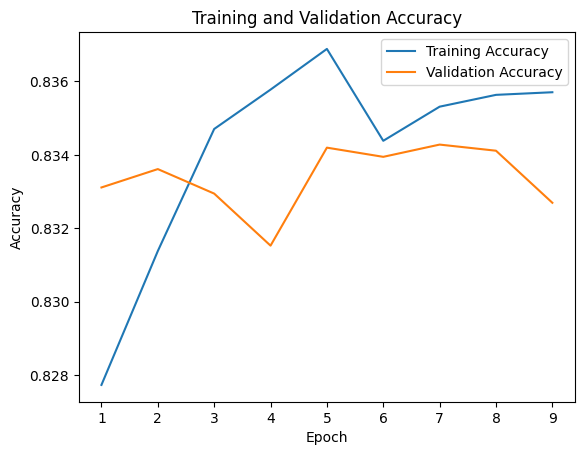

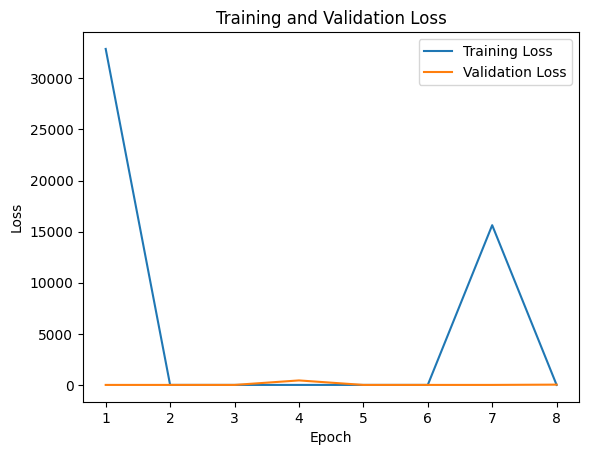

In [20]:
# Plot training and validation accuracy
plt.plot(range(1, len(history.history['mse']) ), history.history['mse'][1:], label='Training MSE')
plt.plot(range(1, len(history.history['val_mse']) ), history.history['val_mse'][1:], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('lstm_accuracy_plot.png')  # Save the plot as an image
plt.show()

# Plot training and validation loss starting from epoch 1
plt.plot(range(1, len(history.history['loss']) ), history.history['loss'][1:], label='Training Loss')
plt.plot(range(1, len(history.history['val_loss']) ), history.history['val_loss'][1:], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('lstm_loss_plot.png')  # Save the plot as an image
plt.show()

#### test

In [26]:
# 영어경로로 해야됨, 한글이 경로안에 포함되있으면 못 읽음
from keras.models import load_model

# Load the saved model
loaded_model = load_model("best_lstm_model.h5")

In [30]:
# Make predictions
predictions = loaded_model.predict([title_test_padded, body_test_padded])

375/375 [==============================] - 20s 51ms/step


## 1D CNN(1D Convolutional Neural Networks)

In [11]:
from sklearn.model_selection import train_test_split
trainX, testX, trainy, testy = train_test_split(ndf[['제목','본문']], ndf['0'], test_size= 0.3, random_state= 42, stratify=ndf['상중하'])

In [12]:
# 토큰화, 벡터화
from keras import preprocessing
from keras.utils import pad_sequences

vocab_size = 1000            # 상위 1000개의 고유한 단어로 제한한다는 의미
max_sequence_length = 100    # 시퀀스에 허용되는 최대 토큰 수(단어,문자  단위)

# num_words에 지정된 만큼만 숫자로 반환 - 부족하면 0으로 채우고, 넘치면 잘림
tokenizer = preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="<oov>")    # oov_tok을 사용하여 사전에 없는 단어집합을 만듬
tokenizer.fit_on_texts(trainX['제목'])


title_train_sequences = tokenizer.texts_to_sequences(trainX['제목'])
title_train_padded = pad_sequences(title_train_sequences, maxlen=max_sequence_length)
title_test_sequences = tokenizer.texts_to_sequences(testX['제목'])
title_test_padded = pad_sequences(title_test_sequences, maxlen=max_sequence_length)


tokenizer.fit_on_texts(trainX['본문'])
body_train_sequences = tokenizer.texts_to_sequences(trainX['본문'])
body_train_padded = pad_sequences(body_train_sequences, maxlen=max_sequence_length)
body_test_sequences = tokenizer.texts_to_sequences(testX['본문'])
body_test_padded = pad_sequences(body_test_sequences, maxlen=max_sequence_length)

In [11]:
from keras.models import Model
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, concatenate, Input, Dropout, LayerNormalization
from keras.constraints import unit_norm
from keras.regularizers import l1_l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

max_sequence_length = 100
# Define input layers
title_input = Input(shape=(max_sequence_length,))
body_input = Input(shape=(max_sequence_length,))

# Shared embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=64, input_length=max_sequence_length)

# Apply the embedding layer to both inputs
title_embedding = embedding_layer(title_input)
body_embedding = embedding_layer(body_input)

In [12]:
title_cnn = Conv1D(64, activation='relu', kernel_size = 4)(title_embedding)
body_cnn = Conv1D(64, activation='relu', kernel_size = 4)(body_embedding)

# Apply Layer Normalization
title_cnn = LayerNormalization()(title_cnn)
body_cnn = LayerNormalization()(body_cnn)

# Apply GlobalMaxPooling1D
title_pooled = GlobalMaxPooling1D()(title_cnn)
body_pooled = GlobalMaxPooling1D()(body_cnn)

# Concatenate the outputs
merged = concatenate([title_pooled, body_pooled])

# Apply Dropout
merged = Dropout(0.4)(merged)  # You can adjust the dropout rate as needed

# Additional Dense layer
merged = Dense(64, activation='relu')(merged)

merged = Dropout(0.2)(merged)  

# Apply Kernel Normalization
merged = Dense(32, activation='linear', kernel_constraint=unit_norm(), kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(merged)

# Output layer
output_layer = Dense(1, activation='linear')(merged) # Use linear activation for regression

# Create the model
model_cnn = Model(inputs=[title_input, body_input], outputs=output_layer)

# Compile the model
model_cnn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mse'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Model Summary
model_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 64)              64000     ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 97, 64)               16448     ['embedding[0][0]']       

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint("best_cnn_model.h5", monitor="val_mse", save_best_only=True)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.005,
    mode='min',  # The indicator must decrease to be considered the best model
    verbose=1,
    restore_best_weights=True
)

# Fit the model with callbacks
history = model_cnn.fit(
    [title_train_padded, body_train_padded],
    trainy,
    epochs=150,  # You can adjust the number of epochs
    batch_size=100,  # You can adjust the batch size
    validation_data=([title_test_padded, body_test_padded], testy),
    callbacks=[checkpoint, early_stopping],
    verbose=1
)


Epoch 1/150
243/243 [==============================] - 19s 69ms/step - loss: 302.4314 - mse: 299.9179 - val_loss: 185.5934 - val_mse: 183.1004
Epoch 2/150


C:\Users\LG\anaconda3\envs\daegu\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


243/243 [==============================] - 20s 81ms/step - loss: 197.2349 - mse: 194.7615 - val_loss: 170.5132 - val_mse: 168.0573
Epoch 3/150
243/243 [==============================] - 19s 77ms/step - loss: 183.2180 - mse: 180.7799 - val_loss: 164.8550 - val_mse: 162.4315
Epoch 4/150
243/243 [==============================] - 15s 64ms/step - loss: 170.9430 - mse: 168.5366 - val_loss: 164.4411 - val_mse: 162.0497
Epoch 5/150
243/243 [==============================] - 13s 53ms/step - loss: 158.5068 - mse: 156.1279 - val_loss: 166.4391 - val_mse: 164.0714
Epoch 6/150
243/243 [==============================] - 13s 52ms/step - loss: 151.8781 - mse: 149.5224 - val_loss: 171.6351 - val_mse: 169.2853
Epoch 7/150
243/243 [==============================] - 13s 55ms/step - loss: 143.5515 - mse: 141.2132 - val_loss: 175.3264 - val_mse: 172.9973
Epoch 8/150
243/243 [==============================] - 15s 62ms/step - loss: 134.9118 - mse: 132.5888 - val_loss: 177.3195 - val_mse: 175.0060
Epoch 9/150

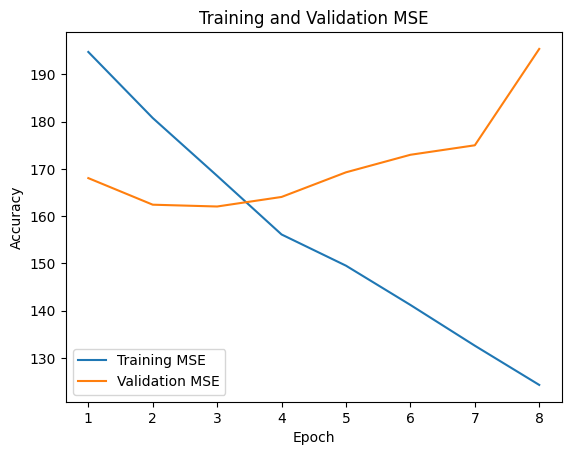

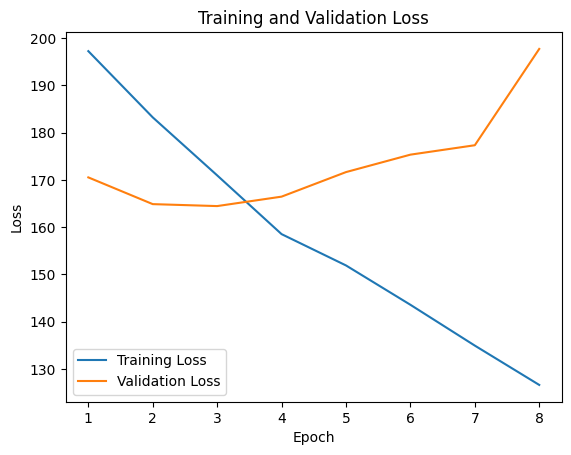

In [15]:
# Plot training and validation accuracy
plt.plot(range(1, len(history.history['mse']) ), history.history['mse'][1:], label='Training MSE')
plt.plot(range(1, len(history.history['val_mse']) ), history.history['val_mse'][1:], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('cnn_accuracy_plot.png')  # Save the plot as an image
plt.show()

# Plot training and validation loss starting from epoch 1
plt.plot(range(1, len(history.history['loss']) ), history.history['loss'][1:], label='Training Loss')
plt.plot(range(1, len(history.history['val_loss']) ), history.history['val_loss'][1:], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('cnn_loss_plot.png')  # Save the plot as an image
plt.show()

#### test

In [2]:
# 영어경로로 해야됨, 한글이 경로안에 포함되있으면 못 읽음
from keras.models import load_model

# Load the saved model
loaded_model = load_model("best_cnn_model.h5")

In [13]:
# Make predictions
predictions = loaded_model.predict([title_test_padded, body_test_padded])
predictions

325/325 [==============================] - 2s 4ms/step


array([[43.65829 ],
       [51.789467],
       [29.805832],
       ...,
       [36.19988 ],
       [46.9752  ],
       [35.075512]], dtype=float32)

In [16]:
predictions = predictions + 15
predictions = np.clip(predictions, a_min=0,a_max=100)
predictions

array([[58.65829 ],
       [66.78947 ],
       [44.805832],
       ...,
       [51.19988 ],
       [61.9752  ],
       [50.075512]], dtype=float32)

In [20]:
evaluation = model_cnn.evaluate([title_test_padded, body_test_padded], testy, verbose=0)

# Extract the metrics
mse, _ = evaluation  # Assuming the first metric is MSE

print(f'Mean Squared Error (MSE): {mse}')

# You can also calculate and print other metrics like MAE and R-squared
from sklearn.metrics import mean_absolute_error, r2_score

predictions = model_cnn.predict([title_test_padded, body_test_padded])

mae = mean_absolute_error(testy, predictions)
r2 = r2_score(testy, predictions)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 164.4410858154297
325/325 [==============================] - 2s 5ms/step
Mean Absolute Error (MAE): 9.078356316500221
R-squared (R2): 0.3022245949731637
